## Formalism selection
Although a checkers board has 64 tiles, only 32 are actually used for the game.<br>
Therefore, we decided to use a list of 32 items to represent the board.<br>
"-1" represents black men, "1" represents white men, "0" represents empty spaces, and 2 or -2 represent white and black kings.

## Running games
At the end of the notebook, you will find instructions to run single or multiple games. Each player can be Human, Montecarlo, MinimaxA-B or random.

In [1]:
#import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
import requests
from collections import Counter
import os
import random
import math
import time
import pickle
import shutil
from IPython.display import HTML # to show the animation in Jupyter
import imageio

#global variables
black = -1
white = 1

# gamelog = []
 
#Open tree file with current knowledge
try:
    tree_file = open("tree.pck","rb")
    montecarlo_tree = pickle.load(tree_file)
    tree_file.close()
except:
    #if it can not find a tree file, will create an empty one.
    tree_file = open("tree.pck", "wb")
    montecarlo_tree = {'-1-1-1-1-1-1-1-1-1-1-1-100000000111111111111': {'nU': 0, 'nN': 0, 'parent': '00000000000000000000000000000000'}}
    pickle.dump(montecarlo_tree, tree_file)
    tree_file.close()
    #initializes tree with root node
    
    

C = 2**0.5
seconds = 1

#Markers shows the name and marker (for display) for each of the tokens
markers = {-2: ('Black king','k*'), -1: ('Black man','ko'), 0: ('Blank','gD'), 
           1: ('White man', 'wo'), 2: ('White king','w*')}

#Reference and test boards
initial_state = [-1 for i in range(1,13)] + [0 for i in range(13,21)] + [1 for i in range(21,33)]
ref_board = [i for i in range(1,33)]
jump_state = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
king_state = [-1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]

jump_once = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
jump_once[14] = 1
jump_once[25] = 0

jump_circle = [0] * 32
jump_circle[9] = -2
jump_circle[13] = 1
jump_circle[14] = 1
jump_circle[21] = 1
jump_circle[22] = 1


king_jumps = [0] * 32
king_jumps[1] = -2
king_jumps[5] = 1
king_jumps[6] = 1
king_jumps[13] = 1
king_jumps[14] = 1
king_jumps[21] = 1
king_jumps[22] = 1


both_jumps = [0] * 32
both_jumps[13] = -2
both_jumps[14] = -1
both_jumps[9] = 1
both_jumps[16] = 1
both_jumps[17] = 1

promote_state = [0] * 32
promote_state[6] = -1
promote_state[9] = 1
promote_state[17] = 1
promote_state[25] = 1

trapped_state = [0] * 32
trapped_state[28] = 1
trapped_state[24] = -1
trapped_state[21] = -1

no_black =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1]
no_white = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2,- 1, -1, 0, 0, 0, -1, -1, -1, -1, -1]

In [2]:
#Index filters for eval function

middle_box = list(map(lambda x: (x//4 in [3, 4]) and ((x - (x//4)*4) in [2,3]), range(32)))
middle_row = list(map(lambda x: x//4 in [3, 4] and not ((x - (x//4)*4) in [2,3]), range(32)))
back_row_black = list(map(lambda x: x//4==0, range(32)))
back_row_white = list(map(lambda x: x//4==7, range(32)))

In [3]:
#Maps for moving and jumping: From each position, a token can only move or jump to 
#very specific positions, e.g. from 10 you can only move to 6, 7, 14, 15.
#These maps capture the movement patterns.

move_map = {}

for i in range(1,33):
    move_map[i] = []
    changes = [4, -4]
    if (i%4 == 0 or (i - 1)%4 == 0) and  (i%8 != 0 and (i - 1)%8 != 0):
        for change in changes:
            if 1 <= i + change <= 32:
                move_map[i].append(i+change)
    else:
        for change in changes:
            for num in [0, 1]:
                if 1 <= i + change + (num * (-1)**((i-1)//4))  <= 32:
                    move_map[i].append(i + change + (num * (-1)**((i-1)//4)))

jump_map = {}
for i in range(1, 33):
    jump_map[i] = set()
    neighbours = move_map[i]
    for neighbour in neighbours:
        neigh_2 = move_map[neighbour]
        for second_neigh in neigh_2:
            if abs(second_neigh - i) == 9 or abs(second_neigh - i) == 7:
                jump_map[i].add((neighbour, second_neigh))

In [4]:
def show_board(state, current=None, turn=None, move=None, fig=None):
    """
    Function to display the current board using pyplot
    """
    all_vals = {}
    for i in range(32):
        val = state[i]
        row = (2*i + (1 - ((i//4)%2)))//8
        col = (2*i + (1 - ((i//4)%2))) - 8 * row
        row = 8 - row - 0.5
        col += 0.5
        text = str(i + 1)
        if val not in all_vals.keys():
            all_vals[val] = []
            all_vals[val].append(markers[val][1])
            all_vals[val].append([])
            all_vals[val].append([])
            all_vals[val].append([])
        all_vals[val][1].append(row)
        all_vals[val][2].append(col)
        all_vals[val][3].append(text)
    
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.set_facecolor('g')
    plt.grid(True)
    
    for val in all_vals.keys():
        x_coords = all_vals[val][2]
        y_coords = all_vals[val][1]
        texts = all_vals[val][3]
        col = 'gold' if val < 0 else 'red' if val > 0 else 'black'
        plt.plot(x_coords, y_coords, all_vals[val][0], markersize=40)
        for x, y, text in zip(x_coords, y_coords, texts):
            plt.text(x-0.15, y-0.15, text, fontsize=14, color=col)
    plt.plot(0,4, 'go', markersize=1)
    plt.plot(4,0, 'go', markersize=1)
    plt.plot(8,4, 'go', markersize=1)
    plt.plot(4,8, 'go', markersize=1)
    if current:
        move_type = {'m':'moved','j':'jumped'}
        if move and turn:
            plt.title(f"Current player: {current}\nPrevious: {turn} {move_type[move[0]]} from {move[1]} to {move[-1]}",fontsize=18)
        else:
            plt.title(f"Current player: {current}",fontsize=18)
    plt.show()

In [5]:
def find_valid_jumps_recursive(board, token_pos, turn, king,paths,prev=[]):
    """
    Finds all valid jump sequences for a given position on a given board, 
    including circular sequences.
    """
    jump_neighbours = jump_map[token_pos]
    jump_neighbours = [i for i in jump_neighbours] if king else [i for i in jump_neighbours if i[1] > token_pos] if turn == -1 else [i for i in jump_neighbours if i[1] < token_pos]
    neighbour_check = lambda x: board[x[0] - 1] == -turn or board[x[0] - 1] == -2 * turn
    jump_check = lambda x: board[x[1] - 1] == 0
    jump_neighbours = [i for i in jump_neighbours if neighbour_check(i) and jump_check(i)]
    if jump_neighbours == []:
        prev = prev + [token_pos]
        if len(prev) > 1:
            paths.append(prev)
    prev = prev + [token_pos]
    for jump in jump_neighbours:
        new_board = board.copy()
        start = token_pos
        stop = jump[1]
        kill = jump[0]
        new_board[stop - 1] = new_board[start - 1]
        new_board[kill - 1] = 0
        new_board[start - 1] = 0
        find_valid_jumps_recursive(new_board, stop, turn, king, paths, prev)

In [6]:
def find_jump_moves(board, turn):
    """
    Finds all possible jump moves for all tokens of a given player.
    Finds full sequence of jump moves.
    Calls find_valid_jumps internally.
    """
    possible_moves = []
    for t in range(1, 33):
        king_check = abs(board[t - 1]) == 2
        if board[t - 1] == turn or board[t - 1] == 2 * turn:
            token_moves = []
            find_valid_jumps_recursive(board, t, turn, king_check, token_moves)
            while token_moves != []:
                move = token_moves.pop()
                move = ['j'] + move
                possible_moves.append(move)
    return possible_moves

def find_normal_moves(board, turn):
    """
    Finds normal non-jump moves for all tokens of a given player.
    """
    possible_moves = []
    for t in range(1,33):
        if board[t-1] == turn:#it is a man
            for d in move_map[t]:
                if board[d-1]==0 and d > t and turn <0: #black advances to bigger cellls
                    possible_moves.append(['m',t,d])
                    
                elif board[d-1]==0 and d < t and turn >0: #white advances to smaller cells
                    possible_moves.append(['m',t,d])
                    
        if board[t-1] == 2*turn:#it is a king
            for d in move_map[t]:
                if board[d-1]==0: #black king moves any direction
                    possible_moves.append(['m',t,d])
    return possible_moves

In [7]:
def move_promote(board, move, display=False):
    """
    Move function that takes a move and a board, and returns a new board state.
    jumps as a single list containing sequence of jumps.
    Promotes token if end is reached.
    """
    new_board = board.copy()
    if move[0] == 'j':
        steps = move[1:]
        start = steps.pop(0)
        while steps != []:
            finish = steps[0]
            kill = set(move_map[start]).intersection(move_map[finish]).pop()
            new_board[finish - 1]  = new_board[start - 1]
            new_board[start - 1] =  0
            new_board[kill - 1] = 0
            start = steps.pop(0)
    else:
        start = move[1]
        finish = move[2]
        new_board[finish - 1] = board[start - 1]
        new_board[start - 1] = 0
    
    row = (2*(finish - 1) + (1 - (((finish - 1)//4)%2)))//8
    black_king_check = new_board[finish - 1] == -1 and row == 7
    white_king_check = new_board[finish - 1] == 1 and row == 0
    if white_king_check or black_king_check:
        new_board[finish - 1] = 2 * new_board[finish - 1]
    plt.close('all')
    if display:
        show_board(new_board)
    return new_board

In [8]:
def available_moves(board, turn):
    """
    Finds all possible moves for a given player.
    Looks for jumps first, and if no jumps are found,
    looks for moves.
    """
    possible_moves = []
    jumps = find_jump_moves(board, turn)
    if jumps == []:
        moves = find_normal_moves(board, turn)
        possible_moves.extend(moves)
    else:
        possible_moves.extend(jumps)
    return len(possible_moves)!=0, possible_moves

In [9]:
def is_end(board, turn):
    """returns true, winner  if its end of game (if tie, winner = 0)
    returns False if game can continue"""
    #case 1 black out of pieces
    black = board.count(-1) + board.count(-2)
    if black == 0:
        return True, 1
    
    #case 2 white out of pieces
    white = board.count(1) + board.count(2)
    if white == 0:
        return True, -1
    
    #case 3 current player has no legal moves
    smoves, moves = available_moves (board, turn)
    if smoves == False:
        return True, -turn
    
    return False, 0

In [10]:
def find_vulnerable(board, turn):
    """
    Find number of vulnerable pieces for a given player on board.
    Called by checkers_eval
    """
    new_board = board.copy()
    jumps = find_jump_moves(board, -turn)
    vulnerable = []
    for jump in jumps:
        steps = jump[1:]
        start = steps.pop(0)
        while steps != []:
            finish = steps[0]
            kill = set(move_map[start]).intersection(move_map[finish]).pop()
            vulnerable.append(kill)
            new_board[finish - 1]  = new_board[start - 1]
            new_board[start - 1] =  0
            new_board[kill - 1] = 0
            start = steps.pop(0)
    return len(set(vulnerable))

def find_not_vulnerable(board, turn):
    """
    Find the number of non-vulnerable pieces for a given player on board.
    Called by checkers_eval
    """
    not_vulnerable = 0
    for i in range(32):
        if board[i]==turn or board[i]== turn * 2:
            neighbours = move_map[i+1]
            if len(neighbours) == 1 or len(neighbours) == 2:
                not_vulnerable += 1
            else:
                if turn == -1:
                    pieces_behind = [board[place-1] < 0 for place in neighbours if place-1 < i]
                    if sum(pieces_behind) == 2:
                        not_vulnerable+=1
                else:
                    pieces_behind = [board[place-1] > 0 for place in neighbours if place-1 > i]
                    if sum(pieces_behind) == 2:
                        not_vulnerable+=1
    return not_vulnerable
            
    

def checkers_eval(board, turn):
    """
    Heuristic evaluation function for checkers. Logics obtained from 
    https://github.com/kevingregor/Checkers/blob/master/Final%20Project%20Report.pdf
    """
    piece_counts = Counter(board)
    pawns = piece_counts[turn] - piece_counts[-turn]
    kings = piece_counts[turn * 2] - piece_counts[-turn * 2]
    mid_box_pieces = [i for (i, filt) in zip(board, middle_box) if filt]
    box_piece_counts = Counter(mid_box_pieces)
    mid_box = box_piece_counts[turn] + box_piece_counts[turn * 2] - box_piece_counts[-turn] - box_piece_counts[-turn * 2]
    mid_row_pieces = [i for (i, filt) in zip(board, middle_row) if filt]
    mr_piece_counts = Counter(mid_row_pieces)
    mid_row = mr_piece_counts[turn] + mr_piece_counts[turn * 2] - mr_piece_counts[-turn] - mr_piece_counts[-turn * 2]
    back_white_pieces = [i for (i, filt) in zip(board, back_row_white) if filt]
    back_black_pieces = [i for (i, filt) in zip(board, back_row_black) if filt]
    back_row = back_white_pieces + back_black_pieces
    back_count = Counter(back_row)
    back = back_count[turn] + back_count[turn * 2] - back_count[-turn] - back_count[-turn * 2]
    vul = find_vulnerable(board, turn) - find_vulnerable(board, -turn)
    not_vul = find_not_vulnerable(board, turn) - find_not_vulnerable(board, -turn)
    
    return 5 * pawns + 7.75 * kings + 4 * back + 2.5 * mid_box + 0.5 * mid_row - 3 * vul + 3 * not_vul


In [11]:
def board_to_string(board):
    """Creates a string representation of the board state. 
    To be used as a dictionary key
    """
    strstate=''
    for c in board:
        strstate = strstate+str(c)
    return strstate

In [12]:
def string_to_board(str_board):
    """
    Converts a board string back to board representation.
    """
    strstate=''
    to_remove = 666
    strstate = list(str_board)
    for s in range(len(strstate)):
        if strstate[s]=='-':
            strstate[s] = -1
            strstate.pop(s+1)
            strstate.append(to_remove)
        else: strstate[s] = int(strstate[s])
    
    while to_remove in strstate: strstate.remove(to_remove)
        
    return strstate

In [13]:
def random_simulation(board, turn):
    """
    Simulates given game state till end using random moves.
    """
    new_board = board.copy()
    end, winner = is_end(new_board, turn)
    while end == False:
        t,m = available_moves(new_board, turn)
        move = random.choice(m)
        #print(turn, ' played ', move)
        new_board = move_promote(new_board, move)
        turn = -turn
        end, winner = is_end(new_board, turn)
    return winner, new_board

In [14]:
def UCB1(nU, nN, C, parentN, goal):
    """
    Calculates the UCB1 value for given parameters.
    """
    
    if goal == 'max':
        v = 1
    if goal == 'min':
        v = -1
        
    if nN == 0:
        return np.inf * v
    
    elif parentN == 0:
        return nU / nN * v
    
    else:
        return ((nU / nN) * v) + (C * ( (math.log(parentN) / nN )**0.5) * v) #v reverses sign to enable argmin

In [15]:
def get_maxUCB1(parent, goal):
    """
    Takes a str_state and goal, check montecarlo_tree and returns a 
    string of the state with best value to roll out (depending on player, best value can be max or min)
    """
    global C
    global montecarlo_tree
    ulist = []
    parentU = montecarlo_tree[parent]['nU']
    parentN = montecarlo_tree[parent]['nN']
    
    #create subtree
    subtree = dict()
                                              
    # Iterate over all the items in dictionary, filter childs and add them to subtree
    for (key, value) in montecarlo_tree.items():
        if parent in montecarlo_tree[key]['parent'].split(';'):
            subtree[key] = value
    #print('subtree', subtree)
        
    for x in subtree.values():
        nU = x['nU']
        nN = x['nN']
        ucb_1 = UCB1(nU, nN, C, parentN, goal)
        #print('ucb1', ucb_1)
        ulist.append (ucb_1)
        #print(ulist)
    if goal == 'max':
        ind = np.argmax(ulist)
    elif goal == 'min':
        ind = np.argmin(ulist)
        
    return list(subtree.keys())[ind]

In [16]:
def sim_leaf(board, turn, last_board):
    """
    Find leaf (node without child) and simulate it. returns board, parent, value
    """
    global montecarlo_tree
    str_board = board_to_string(board)
    str_last_board = board_to_string(last_board)
    
    try:
        t, a = available_moves(board, turn)

        for m in a:
            new_board = move_promote(board,m)
            str_new_board = board_to_string(new_board)

            if str_new_board not in montecarlo_tree.keys():
                w,b = random_simulation(board, turn)
                return str_board, str_last_board, w

            else:
                rboard, rparent, rvalue = sim_leaf(new_board, -turn)
                
    except:
        w,b = random_simulation(board, turn)
        return str_board, str_last_board, w
    
        

In [17]:
def best_move(board, turn, goal):
    """
    Checks montecarlo tree and finds best move for this position and turn.
    """
    global montecarlo_tree
    boards = []
    utils = []
    str_board = board_to_string(board)
    

    for key, values in montecarlo_tree.items():
        if str_board in montecarlo_tree[key]['parent'].split(';'):
            boards.append(key)

            try:
                utils.append(montecarlo_tree[key]['nU'] / montecarlo_tree[key]['nN'])
            except:
                utils.append(math.inf)
    
    if len(utils)==0:
        t,moves = available_moves(board, turn)
        for m in moves:
            b = move_promote(board, m)
            print(board_to_string(b))
        
    if goal == 'max':
        ind = np.argmax(utils)
        best = boards[ind]
        
    elif goal == 'min':
        ind = np.argmin(utils)
        best = boards[ind]
        
    t,moves = available_moves(board, turn)
    
    for m in moves:
        b = move_promote(board, m)
        #print(board_to_string(b))
        if  b == string_to_board(best):
            #print('found move ',m)
            return m
        
    #print('returning empty, available moves=', moves)
    return m

In [18]:
def backprop(parent, value, depth=5):
    """
    Internal function for montecarlo.
    Backpropogates utility of state to its parents.
    """
    global montecarlo_tree
    if depth == 0:
        return
    current = parent
    while current != '00000000000000000000000000000000':
        montecarlo_tree[current]['nU'] += value
        montecarlo_tree[current]['nN'] += 1
        if len(montecarlo_tree[current]['parent'].split(';')) > 1:
            current = montecarlo_tree[current]['parent'].split(';')[0]
#             for n_parent in montecarlo_tree[current]['parent'].split(';'):
#                 backprop(n_parent, value, depth-1)
        else:
            current = montecarlo_tree[current]['parent']
        


def montecarlo(board, turn, seconds, last_board):
    """
    Montecarlo tree search agent (MCTS). Takes a board state  and turn,
    updates the tree while having time,
    returns the best move available after updating the tree.
    """
    global montecarlo_tree 
    global gamelog
    if is_end(board, turn)[0]:
        return False
    
    str_board = board_to_string(board)
    or_turn = turn
    
    #if it is not in tree, add it
    if str_board not in montecarlo_tree.keys():
                #print('creating a child of board')
                #print('son = ', str_new_board)
                #print('parent = ', str_board)
                montecarlo_tree[str_board]={}
                montecarlo_tree[str_board]['nU'] = 0
                montecarlo_tree[str_board]['nN'] = 0
                montecarlo_tree[str_board]['parent'] = board_to_string(last_board)
    
    if turn == 1:
        #play as white
        #max board value
        goal = 'max'
        
    if turn == -1:
        #plays as black
        #min board value
        goal = 'min'
        
    #expand childs of board not already in tree
    t, a = available_moves(board, turn)
    for m in a:
            new_board = move_promote(board,m)
            str_new_board = board_to_string(new_board)
            if str_new_board not in montecarlo_tree.keys():
                #print('creating a child of board')
                #print('son = ', str_new_board)
                #print('parent = ', str_board)
                montecarlo_tree[str_new_board]={}
                montecarlo_tree[str_new_board]['nU'] = 0
                montecarlo_tree[str_new_board]['nN'] = 0
                montecarlo_tree[str_new_board]['parent'] = str_board
            else:
                if str_board not in montecarlo_tree[str_new_board]['parent'].split(';'):
                    montecarlo_tree[str_new_board]['parent'] += ';' + str_board
    
    #updating values while there is time
    start = time.time()
    while time.time()-start < seconds:
            
            #select a child to roll out
            str_to_roll = get_maxUCB1(str_board, goal)#get_maxUCB1 returns a string
            to_roll = string_to_board(str_to_roll)#creates state image
            turn = -turn
            
            t, winner = is_end(to_roll, turn)
            
            #check if rol_out is final
            if t == False:

                #find childless node ('leaf') and simulate it
                str_simulated, str_sim_parent, simvalue = sim_leaf(to_roll, turn, last_board)

                if str_simulated not in montecarlo_tree.keys():
                    #print('creating simulated entry in tree')
                    #print('son = ', str_simulated)
                    #print('parent = ', str_sim_parent)
                    montecarlo_tree[str_simulated]={}
                    montecarlo_tree[str_simulated]['nU'] = simvalue
                    montecarlo_tree[str_simulated]['nN'] = 1
                    montecarlo_tree[str_simulated]['parent'] = str_sim_parent
                else:
                    #print('simulated else....happens when leaf is final')
                    montecarlo_tree[str_simulated]['nU'] += simvalue
                    montecarlo_tree[str_simulated]['nN'] += 1
                    #montecarlo_tree[str_simulated]['parent'] = str_sim_parent

                
                #backpropagate value from simulation
                current = str_sim_parent
                backprop(current, simvalue)   
            
            if t == True:
                pass
    
    #best_move
    m = best_move(board, or_turn, goal)
    return m

In [19]:
def minimax(board, turn, maxD=5):
    """
    Returns the best move based on minimax algorithm with alpha beta pruning.
    A static evaluation is applied after reaching a max depth.
    """
    maxVal = -10**6
    minVal = 10**6
    action_list = []
    _, moves = available_moves(board, turn)
    if not moves:
        return False
    elif len(moves) == 1:
        return moves[0]
    if turn == 1:
        for move in moves:
            new_board = move_promote(board, move)
            val = MinValue(new_board, -turn, -math.inf, math.inf, maxD)
            if val > maxVal:
                maxVal = val
                action_list = [move]
            elif val == maxVal:
                action_list.append(move)
        return random.choice(action_list)
    else:
        for move in moves:
            new_board = move_promote(board, move)
            val = MaxValue(new_board, -turn, -math.inf, math.inf, maxD)
            if val < minVal:
                minVal = val
                action_list = [move]
            elif val == minVal:
                action_list.append(move)
        return random.choice(action_list)
        

def MaxValue(board, turn, alpha, beta, depth):
    """
    Returns the best value for the max player.
    Returns a static evaluation if max depth is reached.
    """
    check, win = is_end(board, turn)
    if check:
        return win * (depth + 1) * 1000
    if depth == 0:
        return checkers_eval(board, turn) * turn
    maxVal = -10**6
    _, moves = available_moves(board, turn)
    for move in moves:
        new_board = move_promote(board, move)
        val = MinValue(new_board, -turn,alpha, beta, depth-1)
        if (val > maxVal):
            maxVal = val
        if (val >= beta):
            return val
        if (val > alpha):
            alpha = val
    return maxVal

def MinValue(board, turn, alpha, beta, depth):
    """
    Returns the best value for the min player.
    Returns a static evaluation if max depth is reached.
    """
    check, win = is_end(board, turn)
    if check:
        return win * (depth + 1) * 1000
    if depth == 0:
        return checkers_eval(board, turn) * turn
    minVal = 10**6
    _, moves = available_moves(board, turn)
    for move in moves:
        new_board = move_promote(board, move)
        val = MaxValue(new_board, -turn, alpha, beta, depth-1)
        if (val < minVal):
            minVal = val
        if (val <= alpha):
            return val
        if (val < beta):
            beta = val
    return minVal

In [20]:
def save_game_images(gamelog):
    """
    Creates game images from gamelog and saves to disk.
    The images are later used to replay the game via gif.
    """
    img_path = os.path.join(os.getcwd(), 'imgs')
    if os.path.exists(img_path):
        shutil.rmtree(img_path)
        os.makedirs(img_path)
    else:
        os.makedirs(img_path)
    for game_no in range(len(gamelog[:-1])):
        all_vals = {}
        for i in range(32):
            val = gamelog[game_no][0][i]
            row = (2*i + (1 - ((i//4)%2)))//8
            col = (2*i + (1 - ((i//4)%2))) - 8 * row
            row = 8 - row - 0.5
            col += 0.5
            text = str(i + 1)
            if val not in all_vals.keys():
                all_vals[val] = []
                all_vals[val].append(markers[val][1])
                all_vals[val].append([])
                all_vals[val].append([])
                all_vals[val].append([])
            all_vals[val][1].append(row)
            all_vals[val][2].append(col)
            all_vals[val][3].append(text)
        
        plt.ioff()
        plt.figure(figsize=(7,7))
        ax = plt.gca()
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_facecolor('g')
        plt.grid(True)
        for val in all_vals.keys():
            x_coords = all_vals[val][2]
            y_coords = all_vals[val][1]
            texts = all_vals[val][3]
            col = 'gold' if val < 0 else 'red' if val > 0 else 'black'
            plt.plot(x_coords, y_coords, all_vals[val][0], markersize=40)
            for x, y, text in zip(x_coords, y_coords, texts):
                plt.text(x-0.15, y-0.15, text, fontsize=14, color=col)
        plt.plot(0,4, 'go', markersize=1)
        plt.plot(4,0, 'go', markersize=1)
        plt.plot(8,4, 'go', markersize=1)
        plt.plot(4,8, 'go', markersize=1)
        move = gamelog[game_no][2]
        turn = gamelog[game_no][1]
        move_type = {'m':'moved','j':'jumped'}
        if game_no == 0:
            plt.title('Game starts. White plays first', fontsize=20)
        if move and turn:
            if game_no == len(gamelog[:-1]) - 1:
                plt.title(f"Previous: {turn} {move_type[move[0]]} from {move[1]} to {move[-1]}\nGame over. Winner: {gamelog[-1]}", fontsize=18)
            else:
                plt.title(f"Previous: {turn} {move_type[move[0]]} from {move[1]} to {move[-1]}", fontsize=18)
        name = str(game_no)
        name = name.zfill(3)
        plt.savefig(os.path.join(img_path, name))
        plt.close()
    return img_path

def display_gif(gif_name):
    """
    Display gif in jupyter notebook.
    
    Parameters:
    
    gif_name : str, name or relative path of gif from current directory
    
    
    Return value:
    
    HTML object displaying gif in jupyter notebook
    """
    return HTML(f'<img src="{gif_name}">')

def display_game(imgs_path):
    """
    Converts the saved images into a gif and creates a gif
    which is saved to directory.
    """
    imgs = os.listdir(imgs_path)
    imgs = sorted(imgs)
    imageio_list = []
    for filename in imgs:
        imageio_list.append(imageio.imread(os.path.join(imgs_path, filename)))
    rng = np.random.RandomState()
    gif_name = str(rng.randint(1000, 2000)) + '.gif'
    duration = 0.75
    gif_path = 'imgs' + '/' + gif_name
    imageio.mimwrite(gif_path, imageio_list, duration=duration, loop=1)
    return gif_path

In [21]:
def reset_montecarlo_tree():
    """resets montecarlo tree to initial state (forgets all knowledge)"""
    global montecarlo_tree
    a = input('Are you sure? all knowledge will be lost. Press 1 to proceed.')
    if a == '1':
        montecarlo_tree = {'-1-1-1-1-1-1-1-1-1-1-1-100000000111111111111': {'nU': 0, 'nN': 0, 'parent': '00000000000000000000000000000000'}}
        return 1
    else:
        return 0

In [22]:
def create_tree_file():
    """create a file to host tree information only done once)"""
    try:
        tree_file = open("tree.pck", "wb")
        pickle.dump(montecarlo_tree, tree_file)
        tree_file.close()
        print('Done')
        return 'OK'
    except:
        print('Error')
        return 'Error'

In [23]:
def tree_report():
    """
    Shows a report of the montecarlo tree main attributes
    """
    global montecarlo_tree
    print('Number of positions stored = ', len(montecarlo_tree))
    print('Distribution of number of parents:')
    n_parents = {1:0,2:0,3:0,4:0,5:0,6:0}
    scores = []
    for key, values in montecarlo_tree.items():
        np = montecarlo_tree[key]['parent'].count(';') + 1
        n_parents[np] +=1
        try:
            score = montecarlo_tree[key]['nU'] / montecarlo_tree[key]['nN']
        except:
            score = 0
        if montecarlo_tree[key]['nN'] > 1:
            scores.append(score)
        
    print(n_parents)
    
    
    sns.histplot(scores)
    plt.title('Distribution of position scores')
    plt.show()

In [24]:
#Game flow manager

def run_game(white_player_1=None, black_player_2=None, board=initial_state):
    """
    Runs the game to end, from given initial board.
    Allows manual selection of player 1 and 2 (montecarlo, minimax, human or random)
    Allows human player to select moves.
    """
    #initial setup for game
    last_board = '00000000000000000000000000000000'
    move_counter=0
    seconds = 1
    turn = 1
    last_player = None
    last_move = None
    gamelog=[(board, last_player, last_move)]
    players = [('Human','h'), ('Minimax with Alpha-Beta pruning','mm'), ('Montecarlo','m'), ('Random','r')]
    short = ['h','mm','m','r']
    
    if (not white_player_1) or (white_player_1 not in short):
        print('Options for White player')
        print(*[str(i[0])+': '+str(i[1][0]) for i in enumerate(players)], sep='\n')
        selected = False
        while not selected:
            try:
                p1 = int(input('Choose a player from list and type number please: '))
                white_player_1 = players[p1][1]
                selected = True
            except:
                continue
        display.clear_output()
    else:
        p1 = short.index(white_player_1)
    if (not black_player_2) or (black_player_2 not in short):
        print('Options for Black player')
        print(*[str(i[0])+': '+str(i[1][0]) for i in enumerate(players)], sep='\n')
        selected = False
        while not selected:
            try:
                p2 = int(input('Choose a player from list and type number please: '))
                black_player_2 = players[p2][1]
                selected = True
            except:
                continue
        display.clear_output()
    else:
        p2 = short.index(black_player_2)
        
    tokens = {-1: 'Black', 1: 'White', 0: 'Draw'}
    
    
    #game itself
    
    print('Game has begun.')
    print('Player 1 is ', players[p1][0], ', color ', 'white')
    print('Player 2 is ', players[p2][0], ', color ', 'black')
    
    
    while move_counter < 121:
        if white_player_1 == 'h':
            t,m = available_moves(board, turn)
            display.clear_output()
            if not m:
                print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                show_board(board)
                gamelog.append(tokens[-turn])
                return -turn, move_counter, gamelog
            show_board(board, 'White', last_player, last_move)
            print(*[str(i[0])+': '+str(i[1]) for i in enumerate(m)], sep='\n')
            selected = False
            while not selected:
                try:
                    a = int(input('Choose a move from list and type number please: '))
                    move = m[a]
                    selected = True
                except:
                    continue
            
        elif white_player_1 == 'mm':
            m = minimax(board, turn)
            if m:
                move = m
            else:
                if black_player_2 == 'h':
                    display.clear_output()
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                    show_board(board)
                else:
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                gamelog.append(tokens[-turn])
                return -turn, move_counter, gamelog
            
        elif white_player_1 == 'm':
            m = montecarlo(board, turn, seconds, last_board)
            if m:
                move = m
            else:
                if black_player_2 == 'h':
                    display.clear_output()
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                    show_board(board)
                else:
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                gamelog.append(tokens[-turn])
                return -turn, move_counter, gamelog
            
        elif white_player_1 == 'r':
            t,m = available_moves(board, turn)
            if t:
                move = random.choice(m)
            else:
                if black_player_2 == 'h':
                    display.clear_output()
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                    show_board(board)
                else:
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                gamelog.append(tokens[-turn])
                return -turn, move_counter, gamelog
            
        last_board = board
        last_player, last_move = 'White', move
        board = move_promote(board,move)
        gamelog.append((board, last_player, last_move))
        move_counter += 1
        
        end, winner = is_end(board, turn)
        if end:
            if black_player_2 == 'h' or white_player_1 == 'h':
                display.clear_output()
                print('Winner is {} in {} moves'.format(tokens[winner], move_counter))
                show_board(board)
            else:
                print('Winner is {} in {} moves'.format(tokens[winner], move_counter))
            gamelog.append(tokens[winner])
            return winner, move_counter, gamelog
        
        turn = -turn
        if not (white_player_1 == 'h' or black_player_2 == 'h'):
            print(move_counter, ', ', end = '')
        
        #black turn
        if black_player_2 == 'h':
            t,m = available_moves(board, turn)
            display.clear_output()
            if not m:
                print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                show_board(board)
                gamelog.append(tokens[-turn])
                return -turn, move_counter, gamelog
            
            show_board(board, 'Black', last_player, last_move)
            print(*[str(i[0])+': '+str(i[1]) for i in enumerate(m)], sep='\n')
            selected = False
            while not selected:
                try:
                    a = int(input('Choose a move from list and type number please: '))
                    move = m[a]
                except:
                    continue
            
        elif black_player_2 == 'mm':
            m = minimax(board, turn)
            if m:
                move = m
            else:
                if white_player_1 == 'h':
                    display.clear_output()
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                    show_board(board)
                else:
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                gamelog.append(tokens[-turn])
                return -turn, move_counter, gamelog
                
        elif black_player_2 == 'm':
            m = montecarlo(board, turn, seconds, last_board)
            if m:
                move = m
            else:
                if white_player_1 == 'h':
                    display.clear_output()
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                    show_board(board)
                else:
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                gamelog.append(tokens[-turn])
                return -turn, move_counter, gamelog
        
        elif black_player_2 == 'r':
            t,m = available_moves(board, turn)
            if t:
                move = random.choice(m)
            else:
                if white_player_1 == 'h':
                    display.clear_output()
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                    show_board(board)
                else:
                    print('Winner is {} in {} moves'.format(tokens[-turn], move_counter))
                gamelog.append(tokens[-turn])
                return -turn, move_counter, gamelog
            
        last_board = board
        last_player, last_move = 'Black', move
        board = move_promote(board,move)
        gamelog.append((board, last_player, last_move))
        
        end, winner = is_end(board, turn)
        move_counter+=1
        if end:
            if white_player_1 == 'h' or black_player_2 == 'h':
                display.clear_output()
                print('Winner is {} in {} moves'.format(tokens[winner], move_counter))
                show_board(board)
            else:
                print('Winner is {} in {} moves'.format(tokens[winner], move_counter))
            gamelog.append(tokens[winner])
            return winner, move_counter, gamelog
        
        turn = -turn
        if not (white_player_1 == 'h' or black_player_2 == 'h'):
            print(move_counter, ', ', end = '')
        
    print('It is a Tie in {} moves'.format(move_counter))
    gamelog.append(tokens[0])
    return 0, move_counter, gamelog

In [25]:
#machine vs machine multigame manager
def multigame_match(player1='m', player2='mm', number_of_games=3):
    """Creates a multigame championship between chosen algorithms"""
    global montecarlo_tree
    wins = {'W': 0, 'B': 0, 'D':0, 'Error': 0, 'Moves': []}
    cumulative = [0]
    
    for i in range(number_of_games):
        print()
        print('Game ', i+1)
        if i%10 == 0:
            tree_file = open("tree.pck","wb")
            pickle.dump(montecarlo_tree, tree_file)
            tree_file.close()
        try:
            win, nmoves, gl = run_game(player1, player2)
            if win == 1:
                wins['W'] += 1
            elif win== -1:
                wins['B'] += 1
            else:
                wins['D'] +=1
        except:
            print('uahoo')
            wins['Error'] += 1
        cumulative.append(win+cumulative[-1])
        wins['Moves'].append(nmoves)
    print()
    print(wins)

    #saves new learning into tree file after finishing
    tree_file = open("tree.pck","wb")
    pickle.dump(montecarlo_tree, tree_file)
    tree_file.close()
    
    plt.plot(cumulative)
    plt.show()
    return wins

In [26]:
"""Run this command to create a single game.
you will be prompted for type of player for player 1 and 2.
If only machines play, there will be no board output until the game is finished.
If a human plays, the gameboard will be shown on each turn, along with available moves."""
win, nmoves, gl = run_game()

Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Minimax with Alpha-Beta pruning , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , Winner is Black in 40 moves


In [41]:
"""This command will show a replay for the previous game.
Please run this cell twice. The first time the gif may not display correctly because of a bug in jupyter."""
gif = display_game(save_game_images(gl))
display_gif(gif)


Game  1
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 100 , 101 , 102 , 103 , 104 , 105 , 106 , 107 , 108 , 109 , 110 , 111 , 112 , 113 , 114 , 115 , 116 , 117 , 118 , 119 , 120 , 121 , 122 , It is a Tie in 122 moves

Game  2
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 ,

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , Winner is White in 67 moves

Game  17
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , Winner is White in 79 moves

Game  18
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , Winner is Black in 51 moves

Game  35
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , Winner is White in 36 moves

Game  36
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , Winner is Black in 40 moves

Game  37
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , Winner is White in 49 moves

Game  53
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 100 , 101 , 102 , 103 , 104 , 105 , 106 , 107 , 108 , 109 , 110 , 111 , 112 , 113 , 114 , 115 , 116 , 117 , 118 , 119 , 120 , 121 , 122 , It is a 

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , Winner is White in 65 moves

Game  70
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , Winner is White in 55 moves

Game  71
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , Winner is Black in 46 moves

Game  89
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , Winner is Black in 44 moves

Game  90
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , Winner is Black in 52 moves

Game  91
Game has begun.
Player 1 

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , Winner is Black in 50 moves

Game  106
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , Winner is White in 79 moves

Game  107
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 2

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , Winner is White in 61 moves

Game  123
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , Winner is White in 87 moves

Game  124
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , Winner is Black in 92 moves

Game  139
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , Winner is White in 61 moves

Game  140
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  bla

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , Winner is Black in 52 moves

Game  157
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , Winner is Black in 46 moves

Game  158
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 5

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , Winner is Black in 62 moves

Game  174
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 100 , 101 , 102 , 103 , 104 , 105 , 106 , 107 , 108 , 109 , 110 , 111 , 112 , 11

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , Winner is White in 45 moves

Game  190
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , Winner is Black in 44 moves

Game  191
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 6

1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , Winner is White in 53 moves

Game  207
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , Winner is Black in 48 moves

Game  208
Game has begun.
Player 1 is  Montecarlo , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 5

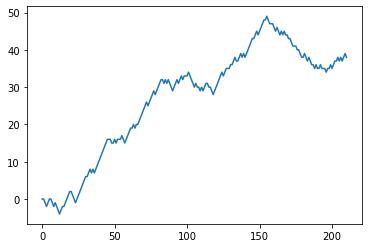

{'W': 105,
 'B': 67,
 'D': 38,
 'Error': 0,
 'Moves': [122,
  88,
  98,
  57,
  63,
  122,
  102,
  96,
  77,
  74,
  52,
  50,
  45,
  61,
  122,
  67,
  79,
  65,
  29,
  122,
  42,
  34,
  100,
  42,
  35,
  56,
  55,
  49,
  73,
  75,
  122,
  67,
  51,
  51,
  36,
  40,
  45,
  43,
  43,
  41,
  65,
  93,
  51,
  48,
  34,
  122,
  122,
  88,
  122,
  42,
  86,
  49,
  122,
  122,
  51,
  46,
  64,
  49,
  61,
  61,
  44,
  122,
  61,
  70,
  47,
  122,
  41,
  67,
  65,
  55,
  95,
  81,
  54,
  43,
  57,
  85,
  69,
  52,
  42,
  45,
  46,
  63,
  122,
  78,
  39,
  37,
  59,
  46,
  44,
  52,
  59,
  67,
  47,
  74,
  85,
  77,
  42,
  49,
  122,
  122,
  67,
  96,
  82,
  52,
  50,
  79,
  43,
  122,
  38,
  45,
  102,
  75,
  78,
  122,
  88,
  122,
  50,
  48,
  69,
  52,
  49,
  61,
  87,
  55,
  72,
  61,
  39,
  122,
  122,
  58,
  122,
  77,
  93,
  54,
  122,
  45,
  61,
  92,
  61,
  100,
  55,
  41,
  53,
  49,
  45,
  122,
  39,
  38,
  54,
  59,
  81,
  49,
  63,
  

In [38]:
"""
This command will launch a championship of n games between selected algorithms and reporte results.
The default selections are
Player 1: Montecarlo
Player 2: Minimax with Alpha-Beta pruning
"""
multigame_match(player1='m', player2='m', number_of_games=210)

Number of positions stored =  241042
Distribution of number of parents:
{1: 237942, 2: 2793, 3: 265, 4: 40, 5: 2, 6: 0}


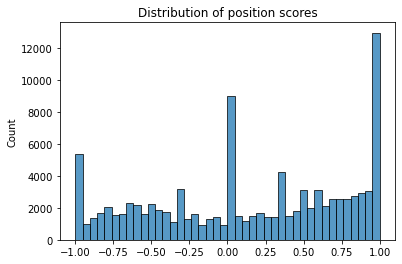

In [46]:
tree_report()


Game  1
Game has begun.
Player 1 is  Minimax with Alpha-Beta pruning , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , Winner is White in 35 moves

Game  2
Game has begun.
Player 1 is  Minimax with Alpha-Beta pruning , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , Winner is White in 37 moves

Game  3
Game has begun.
Player 1 is  Minimax with Alpha-Beta pruning , color  white
Player 2 is  Montecarlo , color  black
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , Winner is White in 

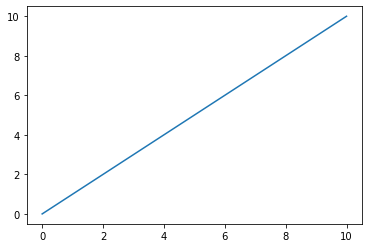

{'W': 10,
 'B': 0,
 'D': 0,
 'Error': 0,
 'Moves': [35, 37, 47, 45, 63, 38, 37, 49, 43, 51]}

In [45]:
multigame_match(player1='mm', player2='m', number_of_games=10)